In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
# 데이터셋을 로드하고 전처리합니다.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CIFAR-10 데이터셋을 다운로드하고 로드합니다.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:18<00:00, 9044661.08it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [4]:
# torchvision.models 모듈을 사용하여 사전 정의된 CNN 모델을 불러옵니다.
import torchvision.models as models

# Pretrained VGG16 모델 사용 (사전 훈련된 가중치 사용)
model = models.vgg16(pretrained=True)

# CIFAR-10 데이터셋의 클래스 수에 맞게 마지막 레이어를 수정합니다.
model.classifier[6] = nn.Linear(4096, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 138MB/s]


In [5]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
# GPU가 사용 가능한지 확인하고, 사용할 수 있다면 device를 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


In [7]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
# 모델 훈련 함수
def train_model(model, trainloader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 순전파, 역전파, 최적화
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

In [9]:
# 모델 평가 함수
def evaluate_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

In [10]:
model = model.to(device)

In [11]:
# 모델 훈련
train_model(model, trainloader, criterion, optimizer, num_epochs=1)

[Epoch 1, Batch 2000] loss: 0.794
Finished Training


In [12]:
# 모델 평가
evaluate_model(model, testloader)

Accuracy of the network on the 10000 test images: 83.39%


In [13]:
import torch.nn.functional as F  # F를 nn.functional 모듈로 임포트
# 직접 구현한 CNN 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 첫 번째 합성곱 층: 입력 채널 3, 출력 채널 6, 커널 크기 5
        self.pool = nn.MaxPool2d(2, 2)   # 최대 풀링 층: 커널 크기 2, 스트라이드 2
        self.conv2 = nn.Conv2d(6, 16, 5) # 두 번째 합성곱 층: 입력 채널 6, 출력 채널 16, 커널 크기 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 첫 번째 완전 연결 층: 입력 크기 16*5*5, 출력 크기 120
        self.fc2 = nn.Linear(120, 84)         # 두 번째 완전 연결 층: 입력 크기 120, 출력 크기 84
        self.fc3 = nn.Linear(84, 10)          # 세 번째 완전 연결 층: 입력 크기 84, 출력 크기 10 (클래스 수)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 첫 번째 합성곱 층 -> ReLU -> 풀링
        x = self.pool(F.relu(self.conv2(x))) # 두 번째 합성곱 층 -> ReLU -> 풀링
        x = x.view(-1, 16 * 5 * 5)           # 특성 맵을 1차원 벡터로 변환
        x = F.relu(self.fc1(x))              # 첫 번째 완전 연결 층 -> ReLU
        x = F.relu(self.fc2(x))              # 두 번째 완전 연결 층 -> ReLU
        x = self.fc3(x)                      # 세 번째 완전 연결 층
        return x

In [14]:
# 모델 인스턴스 생성
net = Net()

In [15]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [16]:
net = net.to(device)

In [17]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
# 모델 훈련
train_model(net, trainloader, criterion, optimizer, num_epochs=10)

[Epoch 1, Batch 2000] loss: 2.190
[Epoch 2, Batch 2000] loss: 1.611
[Epoch 3, Batch 2000] loss: 1.436
[Epoch 4, Batch 2000] loss: 1.298
[Epoch 5, Batch 2000] loss: 1.212
[Epoch 6, Batch 2000] loss: 1.127
[Epoch 7, Batch 2000] loss: 1.068
[Epoch 8, Batch 2000] loss: 1.026
[Epoch 9, Batch 2000] loss: 0.980
[Epoch 10, Batch 2000] loss: 0.950
Finished Training


In [19]:
# 모델 평가
evaluate_model(net, testloader)

Accuracy of the network on the 10000 test images: 61.57%


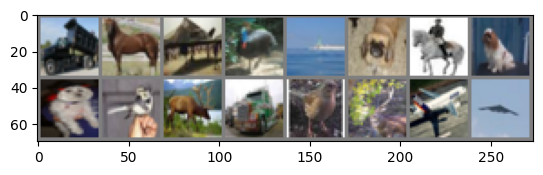

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))